# Is our main food production model efficient enough to feed them all ?


## introduction :
A lot of new agricultural model are nowaday opposed to the dominant one (organic agriculture, permaculture ...) and their main criticism is on how efficient are they to provide food for everyone.
But we never as the other way : is the actual model capable of been enhanced enough to ensure population growth ?
Thus, we will take a look of evolution of agriculture in the last year and see if the trend let us ensure enhancing for the future


Explain the data source


## Part 1 : How can we describe the current world production of food and how has it evolved for the last decades?

What's inside :
Maps representing normalized value of yield for severals type of crops

As a starting point, let's study the current world distribution of food production. Food production can be divided into several subsets, such as meat production, fruits/vegetables production, cereals production... To draw a global vision of the topic, let's study different big classes of food.  

#### 1) Meat production

In [107]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import folium
import json
#from ipywidgets import IntSlider, interact
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.decomposition import PCA
from scipy import stats
from sklearn import preprocessing

In [2]:
# Opening database
df_livestock_prim = pd.read_csv('./data/current_FAO/raw_files/Production_LivestockPrimary_E_All_Data_(Normalized).csv.zip',sep=',',encoding='latin-1')

To study the evolution of the quantity of meat production, we will use a dataset from the FAO database. We will first take a look at its structure. 

In [44]:
# Visualizing the first dataframe
df_livestock_prim.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1961,1961,1000 Head,4000.0,F
1,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1962,1962,1000 Head,4400.0,F
2,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1963,1963,1000 Head,4600.0,F
3,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1964,1964,1000 Head,4800.0,F
4,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1965,1965,1000 Head,5200.0,F


This dataframe contains information about the production of meat, eggs and milk products. It also contains several code that helps to refer to certain class of food. The items are already grouped by bigger families in the dataset. The 3 families we will keep on studying are  *Meat, Total* (item 1765), *Milk, Total* (item 1780) and *Eggs Primary* (item 1783). The meat group doesn't exist as the description says on the website, hence we have to create it ourself. We only keep the production expressed in tonnes.

In [113]:
livestock = df_livestock_prim.copy()

meat_items = [1806, 1122, 1084, 972, 1137, 944, 1094, 1070, 1077, 1032, 1120, 1124, 1161, 1055, 1775, 1144, 1154, 1012, 1770, 1087, 1108, 1089, 947, 1127, 867, 1058, 1069, 1163, 1017, 1073, 1097, 1111, 1166, 1158, 1035, 1808, 1141, 977, 1765, 1080, 1167, 1083, 1807,1176]
livestock_meat = livestock[livestock['Item Code'].isin(meat_items)]
livestock_meat = livestock_meat[livestock_meat.Element == 'Production'][livestock_meat.Unit=='tonnes']

livestock_meat = livestock_meat.set_index(['Area', 'Area Code','Year'])
livestock_meat.head()

/home/clelie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Item Code                    Item  Element Code  \
Area        Area Code Year                                                    
Afghanistan 2         1961       1137  Meat indigenous, camel          5510   
                      1962       1137  Meat indigenous, camel          5510   
                      1963       1137  Meat indigenous, camel          5510   
                      1964       1137  Meat indigenous, camel          5510   
                      1965       1137  Meat indigenous, camel          5510   

                               Element  Year Code    Unit   Value Flag  
Area        Area Code Year                                              
Afghanistan 2         1961  Production       1961  tonnes  3600.0   Fc  
                      1962  Production       1962  tonnes  4031.0   Fc  
                      1963  Production       1963  tonnes  5031.0   Fc  
                      1964  Production       1964  tonnes  4680.0   Fc  
                      1965  Production       1965  tonnes  4320.0   Fc

In [114]:
livestock_meat = livestock_meat.groupby(level=['Area', 'Area Code', 'Year']).sum(level='Value')

# Redefine the different columns that have been summed up
livestock_meat = livestock_meat.reset_index()
livestock_meat['Item Code'] = 1765
livestock_meat['Year Code'] = livestock_meat['Year']
livestock_meat['Item'] = 'Meat, Total'
livestock_meat['Element Code'] = 1137
livestock_meat['Unit'] = 'tonnes'
livestock_meat['Element'] = 'Production'

In [115]:
livestock_meat.head()

,Area,Area Code,Year,Element,Element Code,Item,Item Code,Unit,Value,Year Code
0,Afghanistan,2,1961,Production,1137,"Meat, Total",1765,tonnes,641344.0,1961
1,Afghanistan,2,1962,Production,1137,"Meat, Total",1765,tonnes,654961.0,1962
2,Afghanistan,2,1963,Production,1137,"Meat, Total",1765,tonnes,685880.0,1963
3,Afghanistan,2,1964,Production,1137,"Meat, Total",1765,tonnes,711148.0,1964
4,Afghanistan,2,1965,Production,1137,"Meat, Total",1765,tonnes,741533.0,1965


In [116]:
# Keep only the eggs and the milk products
items = [1780, 1783]
livestock = livestock[livestock['Item Code'].isin(items)]
livestock_yield = livestock[livestock.Element == 'Yield']

In [117]:
# Checking if they are missing values
print("Missing values in livestock_yield:", livestock_yield.isnull().sum().sum())

Missing values in livestock_yield: 0


In [118]:
print("Unit for the eggs yield:", livestock_yield[livestock_yield.Item == 'Eggs Primary'].Unit.unique())
print("Unit for the milk yield:", livestock_yield[livestock_yield.Item == 'Milk,Total'].Unit.unique())

Unit for the eggs yield: ['100mg/An']
Unit for the milk yield: ['hg/An']


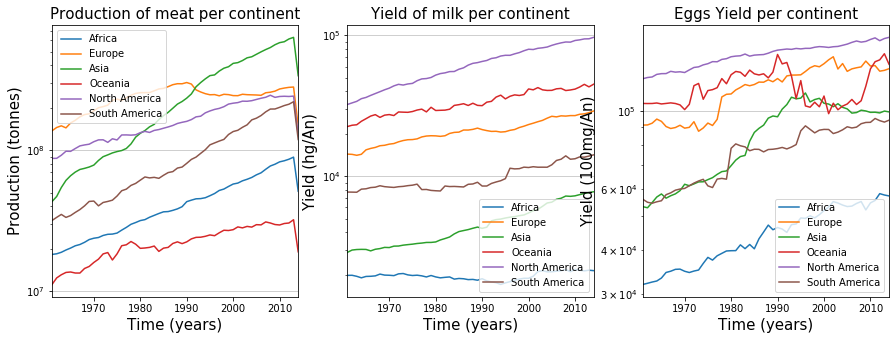

In [120]:
# Visualisation of the evolution of the quantity of livestocks per continent

def select_area(production, area):
    df = production[production.Area == area]
    milk = df[df['Item Code'] == 1780]
    eggs = df[df['Item Code'] == 1783]
    return  milk, eggs

afr_milk, afr_eggs = select_area(livestock_yield, 'Africa')
eu_milk, eu_eggs    = select_area(livestock_yield, 'Europe')
as_milk, as_eggs    = select_area(livestock_yield, 'Asia')
oc_milk, oc_eggs    = select_area(livestock_yield, 'Oceania')
nam_milk, nam_eggs = select_area(livestock_yield, 'Northern America')
sam_milk, sam_eggs = select_area(livestock_yield, 'South America')

afr_meat = livestock_meat[livestock_meat.Area == 'Africa']
eu_meat = livestock_meat[livestock_meat.Area == 'Europe']
as_meat = livestock_meat[livestock_meat.Area == 'Asia']
oc_meat = livestock_meat[livestock_meat.Area == 'Oceania']
nam_meat = livestock_meat[livestock_meat.Area == 'Northern America']
sam_meat = livestock_meat[livestock_meat.Area == 'South America']

fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(1,3,1)

afr_meat.plot('Year', 'Value', logy=True, ax=ax1)
eu_meat.plot('Year', 'Value', logy=True, ax=ax1)
as_meat.plot('Year', 'Value', logy=True, ax=ax1)
oc_meat.plot('Year', 'Value', logy=True, ax=ax1)
nam_meat.plot('Year', 'Value', logy=True, ax=ax1)
sam_meat.plot('Year', 'Value', logy=True, ax=ax1)
ax1.set_title('Production of meat per continent', fontsize=15)
ax1.set_xlabel('Time (years)', fontsize=15)
ax1.set_ylabel('Production (tonnes)', fontsize=15)
ax1.legend(['Africa', 'Europe', 'Asia', 'Oceania', 'North America', 'South America'])
ax1.grid(axis='y', alpha=0.75)

ax2 = fig.add_subplot(1,3,2)

afr_milk.plot('Year', 'Value', logy=True, ax=ax2)
eu_milk.plot('Year', 'Value', logy=True, ax=ax2)
as_milk.plot('Year', 'Value', logy=True, ax=ax2)
oc_milk.plot('Year', 'Value', logy=True, ax=ax2)
nam_milk.plot('Year', 'Value', logy=True, ax=ax2)
sam_milk.plot('Year', 'Value', logy=True, ax=ax2)
ax2.set_title('Yield of milk per continent', fontsize=15)
ax2.set_xlabel('Time (years)', fontsize=15)
ax2.set_ylabel('Yield (hg/An)', fontsize=15)
ax2.legend(['Africa', 'Europe', 'Asia', 'Oceania', 'North America', 'South America'])
ax2.grid(axis='y', alpha=0.75)

ax3 = fig.add_subplot(1,3,3)

afr_eggs.plot('Year', 'Value', logy=True, ax=ax3)
eu_eggs.plot('Year', 'Value', logy=True, ax=ax3)
as_eggs.plot('Year', 'Value', logy=True, ax=ax3)
oc_eggs.plot('Year', 'Value', logy=True, ax=ax3)
nam_eggs.plot('Year', 'Value', logy=True, ax=ax3)
sam_eggs.plot('Year', 'Value', logy=True, ax=ax3)
ax3.set_title('Eggs Yield per continent', fontsize=15)
ax3.set_xlabel('Time (years)', fontsize=15)
ax3.set_ylabel('Yield (100mg/An)', fontsize=15)
ax3.legend(['Africa', 'Europe', 'Asia', 'Oceania', 'North America', 'South America'])
ax3.grid(axis='y', alpha=0.75)

The global evolution is increasing as expected. It seems that we have a missing value for the meat production at the year 2018. 
Let's try to visualize those graphs on a folium map. First, let's take a look at the distribution of the values.

Text(0.5, 1.0, 'Distribution of the values taken in livestock_yield')

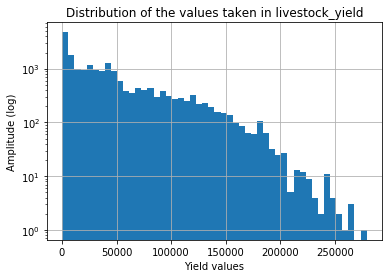

In [127]:
# We now want to study the stocks for each country
livestock_yield_country = livestock_yield[livestock_yield['Area Code'] < 5000] # to get rid of the groups such as the continents
# Plot the distribution of the values taken in the row 'Value'
livestock_yield_country.Value.hist(bins = 50, log=True)
plt.xlabel('Yield values')
plt.ylabel('Amplitude (log)')
plt.title('Distribution of the values taken in livestock_yield')

A logarithm scale seems appropriated for this case.

In [129]:
# Create a new column with the log value of each stock value
livestock_yield_country['Log Value'] = livestock_yield_country.Value.transform(lambda x:round(np.log(x)))
livestock_yield_country['Log Value'] = livestock_yield_country['Log Value'].replace(-np.inf, 0)

# Do the same with the meat dataset
livestock_meat_country = livestock_meat[livestock_meat['Area Code'] < 5000]
livestock_meat_country['Log Value'] = livestock_meat_country.Value.transform(lambda x:round(np.log(x)))
livestock_meat_country['Log Value'] = livestock_meat_country['Log Value'].replace(-np.inf, 0)

/home/clelie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/clelie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/clelie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Now, we have to prepare the map with our json file 'countries.json'.

In [130]:
# Preparing the map
json_file = pd.read_json("countries.json")
df_json = pd.DataFrame({'Area': json_file['name'], 'id': json_file['cca3']})
df_json.head()

,Area,id
0,"{'common': 'Aruba', 'official': 'Aruba', 'nati...",ABW
1,"{'common': 'Afghanistan', 'official': 'Islamic...",AFG
2,"{'common': 'Angola', 'official': 'Republic of ...",AGO
3,"{'common': 'Anguilla', 'official': 'Anguilla',...",AIA
4,"{'common': 'Åland Islands', 'official': 'Åland...",ALA


In [131]:
# Change the format for the name column by taking the common name of each country
def name_json(df):
    df_size = len(df)
    for i in range(df_size):
        df.Area[i] = df.Area[i]['common'][0:len(df.Area[i]['common'])]
    return df

df_json = name_json(df_json)
df_json.head()

,Area,id
0,Aruba,ABW
1,Afghanistan,AFG
2,Angola,AGO
3,Anguilla,AIA
4,Åland Islands,ALA


In [132]:
# Dealing with the different ways to call a same country
def replace_values_area(df):
    df[df.Area == 'United States'] = df[df.Area == 'United States'].replace('United States', 'United States of America')
    df[df.Area == 'Russia'] = df[df.Area == 'Russia'].replace('Russia', 'Russian Federation')
    df[df.Area == 'Bolivia'] = df[df.Area == 'Bolivia'].replace('Bolivia', 'Bolivia (Plurinational State of)')
    df[df.Area == 'Venezuela'] = df[df.Area == 'Venezuela'].replace('Venezuela', 'Venezuela (Bolivarian Republic of)')
    df[df.Area == 'Ivory Coast'] = df[df.Area == 'Ivory Coast'].replace('Ivory Coast', 'Côte d\'Ivoire')
    df[df.Area == 'DR Congo'] = df[df.Area == 'DR Congo'].replace('DR Congo', 'Democratic Republic of the Congo')
    df[df.Area == 'Republic of the Congo'] = df[df.Area == 'Republic of the Congo'].replace('Republic of the Congo', 'Congo')   
    df[df.Area == 'Moldova'] = df[df.Area == 'Moldova'].replace('Moldova', 'Republic of Moldova')
    df[df.Area == 'Syria'] = df[df.Area == 'Syria'].replace('Syria', 'Syrian Arab Republic')
    df[df.Area == 'Iran'] = df[df.Area == 'Iran'].replace('Iran', 'Iran (Islamic Republic of)')
    df[df.Area == 'Vietnam'] = df[df.Area == 'Vietnam'].replace('Vietnam', 'Viet Nam')
    df[df.Area == 'Laos'] = df[df.Area == 'Laos'].replace('Laos', 'Lao People\'s Democratic Republic')
    df[df.Area == 'North Korea'] = df[df.Area == 'North Korea'].replace('North Korea', 'Democratic People\'s Republic of Korea')
    df[df.Area == 'South Korea'] = df[df.Area == 'South Korea'].replace('South Korea', 'Republic of Korea')
    df[df.Area == 'Tanzania'] = df[df.Area == 'Tanzania'].replace('Tanzania', 'United Republic of Tanzania')
    df[df.Area == 'Taiwan'] = df[df.Area == 'Taiwan'].replace('Taiwan', 'China, Taiwan Province of')
    df[df.Area == 'Brunei'] = df[df.Area == 'Brunei'].replace('Brunei', 'Brunei Darussalam')
    return(df)

df_json = replace_values_area(df_json)

In [135]:
# Merge the df_json dataframe to our initial dataframe
# They will have the right id for each country
livestock_yield_country = livestock_yield_country.merge(df_json, on='Area', how='inner')
livestock_meat_country = livestock_meat_country.merge(df_json, on='Area', how='inner')
livestock_yield_country.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Log Value,id_x,id_y,id
0,2,Afghanistan,1783,Eggs Primary,5410,Yield,1961,1961,100mg/An,25000.0,Fc,10.0,AFG,AFG,AFG
1,2,Afghanistan,1783,Eggs Primary,5410,Yield,1962,1962,100mg/An,25000.0,Fc,10.0,AFG,AFG,AFG
2,2,Afghanistan,1783,Eggs Primary,5410,Yield,1963,1963,100mg/An,25000.0,Fc,10.0,AFG,AFG,AFG
3,2,Afghanistan,1783,Eggs Primary,5410,Yield,1964,1964,100mg/An,25000.0,Fc,10.0,AFG,AFG,AFG
4,2,Afghanistan,1783,Eggs Primary,5410,Yield,1965,1965,100mg/An,24615.0,Fc,10.0,AFG,AFG,AFG


In [136]:
# Example : Yield of milk in 2000
map1 = folium.Map(location=[0,0], zoom_start=2)
state_geo_path = r'countries.geo.json'
geo_json_data = json.load(open(state_geo_path))
folium.GeoJson(geo_json_data).add_to(map1)
data = livestock_yield_country[livestock_yield_country.Year == 2000][livestock_yield_country['Item Code']==1780]

map1.choropleth(geo_data=geo_json_data, data=data,
             columns=['id', 'Log Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.6, line_opacity=0.2,
             legend_name='Production of Cattle and Buffaloes')
map1

/home/clelie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/clelie/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


This example is quite consistent. The countries that have the best yield for milk are in dark purple and correspond to the countries that consume the most this type of food. Asian and African countries don't produce that much.
In the future, we would like to add a TimeSlider to visualize the evolution of the map during time but we haven't found any way to do it for now.

#### 2) Fruit/Vegetable production

A new dataset is used to study the production and the yield of fruits and vegetables. Let's visualize it and preprocess it.

In [12]:
df_prod_crops = pd.read_csv('./data/current_FAO/raw_files/Production_Crops_E_All_Data_(Normalized).csv.zip',sep=',',encoding='latin-1')
df_prod_crops.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0.0,F
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,1976,ha,5900.0,F
2,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1977,1977,ha,6000.0,F
3,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1978,1978,ha,6000.0,F
4,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1979,1979,ha,6000.0,F


The same structure is provided for this dataset. Grouped items exist and a vegetable group is provided. However, the fruit group doesn't seem to exist. We have to create it ourself.

In [13]:
crops = df_prod_crops.copy()

# Create a fruit list
fruit = [515, 526, 572, 486, 558, 552, 461, 591, 531, 530, 554, 550, 577, 569, 512, 619, 542, 541, 603, 549, 507, 560, 592, 497, 571, 568, 490, 600, 534, 521, 587, 574, 489, 536, 523, 547, 544, 495, 567]
crops_fruit = crops[crops['Item Code'].isin(fruit)]
crops_fruit = crops_fruit.set_index(['Area', 'Area Code','Year', 'Element'])
crops_fruit.head()

/home/clelie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Item Code    Item  Element Code  \
Area        Area Code Year Element                                           
Afghanistan 2         1961 Area harvested       1738  Apples          5312   
                      1962 Area harvested       1738  Apples          5312   
                      1963 Area harvested       1738  Apples          5312   
                      1964 Area harvested       1738  Apples          5312   
                      1965 Area harvested       1738  Apples          5312   

                                           Year Code Unit   Value Flag  
Area        Area Code Year Element                                      
Afghanistan 2         1961 Area harvested       1961   ha  2220.0    F  
                      1962 Area harvested       1962   ha  2220.0    F  
                      1963 Area harvested       1963   ha  2220.0    F  
                      1964 Area harvested       1964   ha  2350.0    F  
                      1965 Area harvested       1965   ha  2480.0    F

In [19]:
crops_fruit = crops_fruit.groupby(level=['Area', 'Area Code', 'Year', 'Element']).sum(level='Value')

# Redefine the different columns that have been summed up
crops_fruit = crops_fruit.reset_index()
crops_fruit['Item Code'] = 1738
crops_fruit['Year Code'] = crops_fruit['Year']
crops_fruit['Item'] = 'Fruit'
crops_fruit['Element Code'][crops_fruit['Element'] == 'Production'] = 5510
crops_fruit['Element Code'][crops_fruit['Element'] == 'Area harvested'] = 5312
crops_fruit['Element Code'][crops_fruit['Element'] == 'Yield'] = 5419
crops_fruit['Unit'][crops_fruit['Element'] == 'Production'] = 'tonnes'
crops_fruit['Unit'][crops_fruit['Element'] == 'Area harvested'] = 'ha'
crops_fruit['Unit'][crops_fruit['Element'] == 'Yield'] = 'hg/ha'

/home/clelie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/clelie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/clelie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/clelie/anaconda3/lib/python3.7/site-p

In [20]:
crops_fruit.head()

,Area,Area Code,Year,Element,Element Code,Item,Item Code,Log Value,Unit,Value,Year Code
0,Afghanistan,2,1961,Area harvested,5312,Fruit,1738,115.0,ha,108699.0,1961
1,Afghanistan,2,1961,Production,5510,Fruit,1738,138.0,tonnes,567200.0,1961
2,Afghanistan,2,1961,Yield,5419,Fruit,1738,153.0,hg/ha,843736.0,1961
3,Afghanistan,2,1962,Area harvested,5312,Fruit,1738,115.0,ha,108550.0,1962
4,Afghanistan,2,1962,Production,5510,Fruit,1738,138.0,tonnes,565000.0,1962


Now we can create the dataframe for the vegetables as well.

In [21]:
crops_veggies = crops[crops['Item Code'] == 1735]
crops_veggies.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
8213,2,Afghanistan,1735,Vegetables Primary,5312,Area harvested,1961,1961,ha,85000.0,A
8214,2,Afghanistan,1735,Vegetables Primary,5312,Area harvested,1962,1962,ha,85000.0,A
8215,2,Afghanistan,1735,Vegetables Primary,5312,Area harvested,1963,1963,ha,85000.0,A
8216,2,Afghanistan,1735,Vegetables Primary,5312,Area harvested,1964,1964,ha,90000.0,A
8217,2,Afghanistan,1735,Vegetables Primary,5312,Area harvested,1965,1965,ha,96000.0,A


As an example, let's visualize the yield of vegetables and fruits per continent since 1961.

/home/clelie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/clelie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


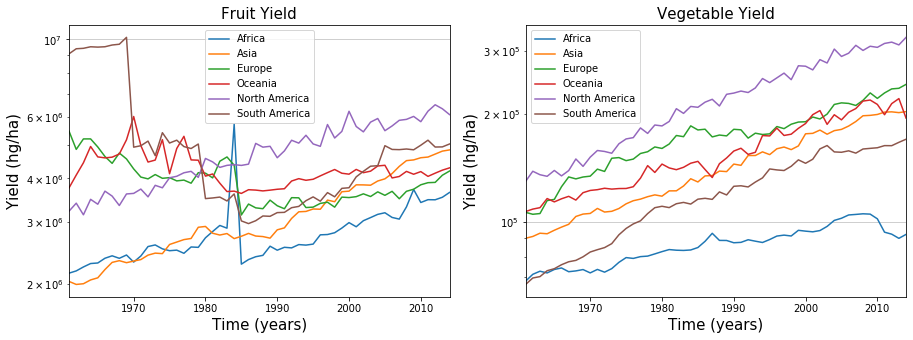

In [30]:
# Compute the log values
crops_fruit['Log Value'] = crops_fruit.Value.transform(lambda x:round(np.log(x)))
crops_fruit['Log Value'] = crops_fruit['Log Value'].replace(-np.inf, 0)

crops_veggies['Log Value'] = crops_veggies.Value.transform(lambda x:round(np.log(x)))
crops_veggies['Log Value'] = crops_veggies['Log Value'].replace(-np.inf, 0)

fruit_yield  = crops_fruit[crops_fruit.Element == 'Yield']
fruit_yield  = fruit_yield.sort_values('Year')

veggies_yield  = crops_veggies[crops_veggies.Element == 'Yield']
veggies_yield  = veggies_yield.sort_values('Year')

fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(1,2,1)

fruit_yield[fruit_yield.Area == 'Africa'].plot('Year', 'Value', logy=True, ax=ax1)
fruit_yield[fruit_yield.Area == 'Asia'].plot('Year', 'Value', logy=True, ax=ax1)
fruit_yield[fruit_yield.Area == 'Europe'].plot('Year','Value', logy=True, ax=ax1)
fruit_yield[fruit_yield.Area == 'Oceania'].plot('Year', 'Value', logy=True, ax=ax1)
fruit_yield[fruit_yield.Area == 'Northern America'].plot('Year', 'Value', logy=True, ax=ax1)
fruit_yield[fruit_yield.Area == 'South America'].plot('Year', 'Value', logy=True, ax=ax1)
ax1.set_title('Fruit Yield', fontsize=15)
ax1.set_xlabel('Time (years)', fontsize=15)
ax1.set_ylabel('Yield (hg/ha)', fontsize=15)
ax1.legend(['Africa', 'Asia', 'Europe', 'Oceania', 'North America', 'South America'])
ax1.grid(axis='y', alpha=0.75)

ax2 = fig.add_subplot(1,2,2)
veggies_yield[veggies_yield.Area == 'Africa'].plot('Year', 'Value', logy=True, ax=ax2)
veggies_yield[veggies_yield.Area == 'Asia'].plot('Year', 'Value', logy=True, ax=ax2)
veggies_yield[veggies_yield.Area == 'Europe'].plot('Year', 'Value', logy=True, ax=ax2)
veggies_yield[veggies_yield.Area == 'Oceania'].plot('Year', 'Value', logy=True, ax=ax2)
veggies_yield[veggies_yield.Area == 'Northern America'].plot('Year', 'Value', logy=True, ax=ax2)
veggies_yield[veggies_yield.Area == 'South America'].plot('Year', 'Value', logy=True, ax=ax2)
ax2.set_title('Vegetable Yield', fontsize=15)
ax2.set_xlabel('Time (years)', fontsize=15)
ax2.set_ylabel('Yield (hg/ha)', fontsize=15)
ax2.legend(['Africa', 'Asia', 'Europe', 'Oceania', 'North America', 'South America'])
ax2.grid(axis='y', alpha=0.75)

Let's use a map to represent this information. We will use the same commands as before.

In [137]:
# Example : Yield of Fruits in 2000

# Merge the df_json dataframe to our initial dataframe
fruit_yield = fruit_yield.merge(df_json, on='Area', how='inner')
veggies_yield = veggies_yield.merge(df_json, on='Area', how='inner')

map2 = folium.Map(location=[0,0], zoom_start=2)
state_geo_path = r'countries.geo.json'
geo_json_data = json.load(open(state_geo_path))
folium.GeoJson(geo_json_data).add_to(map1)
data = fruit_yield[fruit_yield.Year == 2000]

map2.choropleth(geo_data=geo_json_data, data=data,
             columns=['id', 'Log Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.6, line_opacity=0.2,
             legend_name='Production of Cattle and Buffaloes')
map2

#### 3) Cereal production

The cereal production and yield are given in the same data frame as vegetables.

/home/clelie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/clelie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


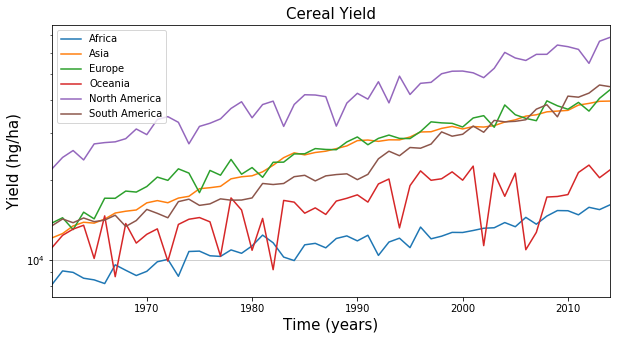

In [29]:
crops_cereals = crops[crops['Item Code'] == 1717]

# Compute the log values
crops_cereals['Log Value'] = crops_cereals.Value.transform(lambda x:round(np.log(x)))
crops_cereals['Log Value'] = crops_cereals['Log Value'].replace(-np.inf, 0)

# Take the yield values for cereals
cereals_yield  = crops_cereals[crops_cereals.Element == 'Yield']
cereals_yield  = cereals_yield.sort_values('Year')

fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(1,1,1)

cereals_yield[cereals_yield.Area == 'Africa'].plot('Year', 'Value', logy=True, ax=ax1)
cereals_yield[cereals_yield.Area == 'Asia'].plot('Year', 'Value', logy=True, ax=ax1)
cereals_yield[cereals_yield.Area == 'Europe'].plot('Year','Value', logy=True, ax=ax1)
cereals_yield[cereals_yield.Area == 'Oceania'].plot('Year', 'Value', logy=True, ax=ax1)
cereals_yield[cereals_yield.Area == 'Northern America'].plot('Year', 'Value', logy=True, ax=ax1)
cereals_yield[cereals_yield.Area == 'South America'].plot('Year', 'Value', logy=True, ax=ax1)
ax1.set_title('Cereal Yield', fontsize=15)
ax1.set_xlabel('Time (years)', fontsize=15)
ax1.set_ylabel('Yield (hg/ha)', fontsize=15)
ax1.legend(['Africa', 'Asia', 'Europe', 'Oceania', 'North America', 'South America'])
ax1.grid(axis='y', alpha=0.75)

Again, the corresponding map follows.

In [138]:
# Example : Yield of Fruits in 2000

# Merge the df_json dataframe to our initial dataframe
cereals_yield = cereals_yield.merge(df_json, on='Area', how='inner')

map3 = folium.Map(location=[0,0], zoom_start=2)
state_geo_path = r'countries.geo.json'
geo_json_data = json.load(open(state_geo_path))
folium.GeoJson(geo_json_data).add_to(map1)
data = cereals_yield[cereals_yield.Year == 2000]

map3.choropleth(geo_data=geo_json_data, data=data,
             columns=['id', 'Log Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.6, line_opacity=0.2,
             legend_name='Production of Cattle and Buffaloes')
map3

Transition :
We took a look at food production efficiency for several plants. 
Is there a way to compute that efficiency for a country to assess their agricultural model ?

## Part 2 : Study of Correlation between Fertilizer Use and Yield using PCA

Aim: we will use the fertilizer and yield data to study how fertilizer use and yields have evolved overtime. As there are many different yields (for different food groups) we will use dimensionality reduction (first with PCA, later with UMAP), on the yield data. 

In [97]:
#reading the FAO data set
fertilizer_area=pd.read_csv('./data/Environment_Fertilizers_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
crops=pd.read_csv('./data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')

For a first exploration of the data, we will look at the year 2016 and the nitrogen fertilizer.

In [96]:
#Determining countries most fertilizer consumer for the last year of using
fertilizer=(fertilizer_area.query('`Item Code` == (3102)')
    .query('`Year Code` == 2016')
    .query('`Area Code` <300') #exclude the grouped countried (i.e. europe, etc)
    .sort_values('Value', ascending=False)
)

fertilizer.head(2)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
2030,59,Egypt,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2016,2016,kg/ha,366.87,Fc
4328,150,Netherlands,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2016,2016,kg/ha,244.89,Fc


For the yields we again take the year 2016, and take the yields based on food group (rather than specific yields for each food item). 

We will replace the na values with 0 because we assume that if no data is available for a given country, they do not produce these foods.

In [100]:
grouped_yields=(crops.query('`Element Code` == 5419') #take yield (not production, area harvested)
        .query('`Year Code` == 2016')
        .query('`Item Code` >1000') #take the grouped foods
        .pivot(index='Area',columns='Item',values='Value')
        .fillna(value=0) 
        .reset_index()
          )
grouped_yields.head(2)

Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fruit Primary,"Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,Afghanistan,19391.0,19816.0,83127.0,16667.0,88201.0,7406.0,119868.0,15984.0,91869.0
1,Africa,14245.0,15261.0,108260.0,13007.0,88514.0,7629.0,85875.0,5437.0,83707.0


Now we define a function which classifies fertilizer use in to low, medium or high values based on percentile.

In [16]:
def ferti_class(x, L): #associate a color to each bin of fertilizer
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

We define a function for performing PCA.
First the value is standardized using StandardScaler and then calculate the two first principal components.

In [17]:
def pre_processing_PCA(df, target, features):
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the countries
    y = df.loc[:,[target]].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    return x

def PCA_processing(df, target, features):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(pre_processing_PCA(df, target, features))
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
    return pca,pd.concat([principalDf, df[[target]]], axis=1)

Next we perform the pca analysis on our yield data, merge this with the fertilizer value for each country and apply the fertilizer classification function defined above (to indicate low, medium or high fertilizer use).

In [18]:
pca,grouped_yield_pca = PCA_processing(grouped_yields,'Area', grouped_yields.columns[1:])
grouped_yield_pca=pd.merge(grouped_yield_pca,fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
grouped_yield_pca['ferti_class']=grouped_yield_pca.Value.apply(lambda x: ferti_class(x, grouped_yield_pca.Value))


Finally, we visualize the results of the PCA.
First, we plot the two principal components and add **a posteriori** colors corresponding to the high, medium and low fertilizer groups.
Then,we show the boxplots of the projected values of PC1 and PC2 by fertilizer groups.
Finally, instead of using a categorical approach, we use a quantitative approach and perform a linear regression between principal components and fertilizer use value. 

Text(0, 0.5, 'Fertilizer use')

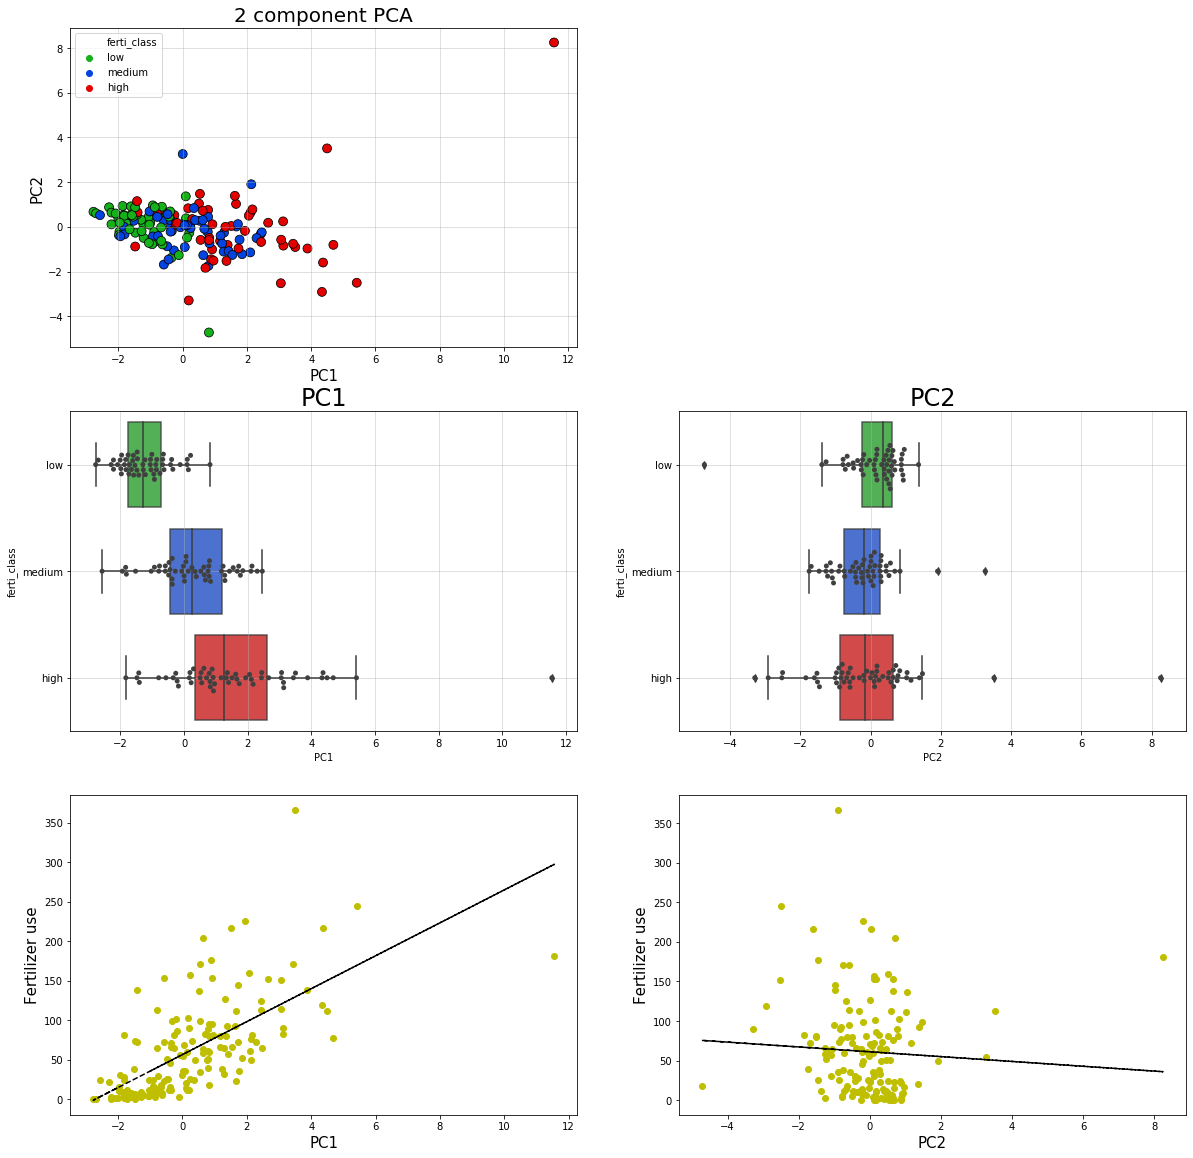

In [19]:
#Viz for 1 year 
figure = plt.figure(figsize = (20,20))
colors = ["green", "blue", "red"]

ax1 = figure.add_subplot(3,2,1)
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('2 component PCA', fontsize = 20)
ax1.grid(alpha=0.5)
ax1 = sns.scatterplot(x='PC1', y='PC2', hue='ferti_class', palette=sns.xkcd_palette(colors), data=grouped_yield_pca, s=80,edgecolor="black")

ax2 = figure.add_subplot(3,2,3)
ax2 = sns.boxplot(x='PC1', y='ferti_class', data=grouped_yield_pca, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax2 = sns.swarmplot(x='PC1', y='ferti_class', data=grouped_yield_pca, color=".25")
ax2.grid(alpha=0.5)
plt.title('PC1', fontsize=24);

ax3 = figure.add_subplot(3,2,4)
ax3 = sns.boxplot(x='PC2', y='ferti_class', data=grouped_yield_pca, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax3 = sns.swarmplot(x='PC2', y='ferti_class', data=grouped_yield_pca, color=".25")
ax3.grid(alpha=0.5)
plt.title('PC2', fontsize=24);

ax4 = figure.add_subplot(3,2,5)
coef = np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.Value,1)
poly1d_fn = np.poly1d(coef)
plt.plot(grouped_yield_pca.PC1,grouped_yield_pca.Value, 'yo',grouped_yield_pca.PC1, poly1d_fn(grouped_yield_pca.PC1), '--k')
ax4.set_xlabel('PC1', fontsize = 15)
ax4.set_ylabel('Fertilizer use', fontsize = 15)

ax5 = figure.add_subplot(3,2,6)
coef = np.polyfit(grouped_yield_pca.PC2,grouped_yield_pca.Value,1)
poly1d_fn = np.poly1d(coef)
plt.plot(grouped_yield_pca.PC2,grouped_yield_pca.Value, 'yo',grouped_yield_pca.PC2, poly1d_fn(grouped_yield_pca.PC2), '--k')
ax5.set_xlabel('PC2', fontsize = 15)
ax5.set_ylabel('Fertilizer use', fontsize = 15)

**Observations:** 
- The first plot shows that the fertilizer groups are not randomly distributed across the PCA. There might be a correlation between principal components and fertilizer use, especially for PC1.
- The boxplots of the projection makes this correlation even clearer for PC1.
- The regression confirms finally this tendancy.

We can observe especially 1 outlier at the top right corner which is United Arab Emirates. It could be interesting to study what makes this country that different than others.

In [129]:
print(stats.shapiro(grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='low']),'\n',
      stats.shapiro(grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='medium']),'\n',
      stats.shapiro(grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='high']))
print('High group cannot be modelize by a normal distribution. As anova is not very robust to normal distribution assumption, we will use a Kruskal Wallis non-parametric test.')

(0.9822317361831665, 0.6246424317359924) 
 (0.9834321141242981, 0.6912586092948914) 
 (0.8739449977874756, 4.023095243610442e-05)
High group cannot be modelize by a normal distribution. As anova is not very robust to normal distribution assumption, we will use a Kruskal Wallis non-parametric test.


In [130]:
import scikit_posthocs as sp

print(stats.kruskal(grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='low'],
                    grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='medium'],
                    grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='high']))

print(sp.posthoc_dunn([grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='low'],
                    grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='medium'],
                    grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='high']]))
print('The groups are significantly different, based on rank test on PC1')

KruskalResult(statistic=73.62301148212293, pvalue=1.0303058983549591e-16)
              1             2             3
1 -1.000000e+00  4.981170e-08  2.505717e-17
2  4.981170e-08 -1.000000e+00  3.467660e-03
3  2.505717e-17  3.467660e-03 -1.000000e+00
The groups are significantly different, based on rank test on PC1


As PC1 seems associated with fertlizer use, we want to know how the yields are represented by the principal components.

In [20]:
df = pd.DataFrame(pca.components_, columns=list(grouped_yields.columns[1:]))
df.head(2)

,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fruit Primary,"Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,0.447310,0.445459,0.064642,0.440154,0.248610,0.308481,0.371344,0.168310,0.283501
1,0.358542,0.359029,-0.236136,0.361944,-0.353178,-0.269843,-0.377510,-0.235045,-0.400590


**Observation:** PC1 relies mostly on Cereals, Coarse Grain, Roots and Tubers, and Pulses. Moreover, the coefficients of those yields are all positive, showing a positive correlation between them and fertilizer use.
We want now to confirm those results by looking at the relationship between those yields independently and fertilizer use.

In [21]:
yields_ferti = pd.merge(grouped_yields,fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')

Text(0, 0.5, 'Fertilizer use')

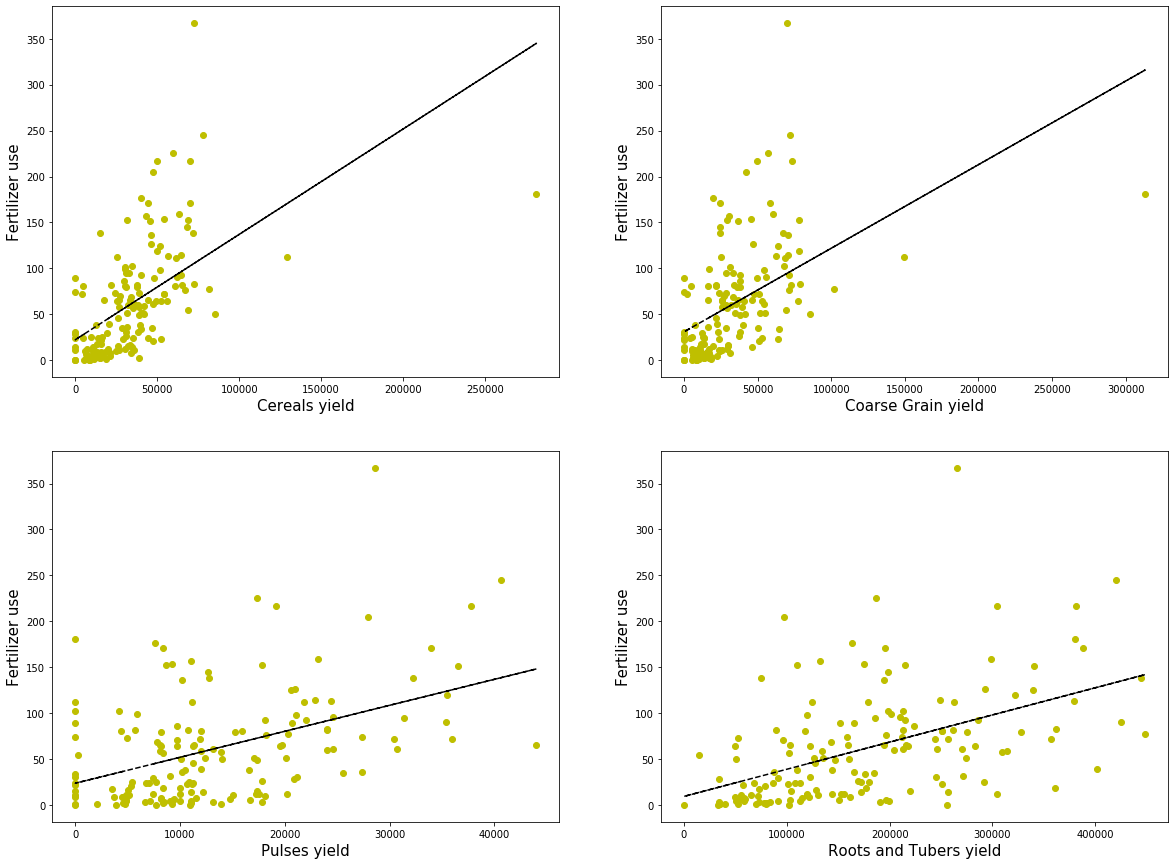

In [22]:
#Viz for 1 year 
figure = plt.figure(figsize = (20,15))

ax1 = figure.add_subplot(2,2,1)
coef = np.polyfit(yields_ferti['Cereals,Total'],yields_ferti.Value,1)
poly1d_fn = np.poly1d(coef)
plt.plot(yields_ferti['Cereals,Total'],yields_ferti.Value, 'yo',yields_ferti['Cereals,Total'], poly1d_fn(yields_ferti['Cereals,Total']), '--k')
ax1.set_xlabel('Cereals yield', fontsize = 15)
ax1.set_ylabel('Fertilizer use', fontsize = 15)

ax2 = figure.add_subplot(2,2,2)
coef = np.polyfit(yields_ferti['Coarse Grain, Total'],yields_ferti.Value,1)
poly1d_fn = np.poly1d(coef)
plt.plot(yields_ferti['Coarse Grain, Total'],yields_ferti.Value, 'yo',yields_ferti['Coarse Grain, Total'], poly1d_fn(yields_ferti['Coarse Grain, Total']), '--k')
ax2.set_xlabel('Coarse Grain yield', fontsize = 15)
ax2.set_ylabel('Fertilizer use', fontsize = 15)

ax3 = figure.add_subplot(2,2,3)
coef = np.polyfit(yields_ferti['Pulses,Total'],yields_ferti.Value,1)
poly1d_fn = np.poly1d(coef)
plt.plot(yields_ferti['Pulses,Total'],yields_ferti.Value, 'yo',yields_ferti['Pulses,Total'], poly1d_fn(yields_ferti['Pulses,Total']), '--k')
ax3.set_xlabel('Pulses yield', fontsize = 15)
ax3.set_ylabel('Fertilizer use', fontsize = 15)

ax4 = figure.add_subplot(2,2,4)
coef = np.polyfit(yields_ferti['Roots and Tubers,Total'],yields_ferti.Value,1)
poly1d_fn = np.poly1d(coef)
plt.plot(yields_ferti['Roots and Tubers,Total'],yields_ferti.Value, 'yo',yields_ferti['Roots and Tubers,Total'], poly1d_fn(yields_ferti['Roots and Tubers,Total']), '--k')
ax4.set_xlabel('Roots and Tubers yield', fontsize = 15)
ax4.set_ylabel('Fertilizer use', fontsize = 15)

**Observation:** As expected, there are positive correlations between the fertilizer use and the presented yields.

However, we did only this analysis for the year 2016. Do we observe the same tendancy for the other years and how does it evolve? 
How this evolution compares with the evolution of fertilizer use? 

We will reproduce the same code for each year to compute the medians of the PC1 for the fertilizer groups for each year.

In [24]:
years = []
PC1_low = []
PC1_medium = []
PC1_high = []
PC1 = []
ferti_low = []
ferti_medium = []
ferti_high = []
ferti = []
proportion_explained = []
for year in range(2002,2017):
    years += [year]
    
    grouped_yield=crops.query('`Element Code` == 5419')\
                                .query('`Year Code` == @year')\
                                .query('`Item Code` >1000')\
                                .pivot(index='Area',columns='Item',values='Value')\
                                .fillna(value=0)\
                                .reset_index()

    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])


    fertilizer=(fertilizer_area.query('`Item Code` == (3102)')
        .query('`Year Code` == @year')
        .query('`Area Code` <300')
        .sort_values('Value', ascending=False)
    )

    grouped_yield_pca=pd.merge(grouped_yield_pca,fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
    grouped_yield_pca['ferti_class']=grouped_yield_pca.Value.apply(lambda x: ferti_class(x, grouped_yield_pca.Value))

    PC1_low += [np.median(grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='low'])]
    PC1_medium += [np.median(grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='medium'])]
    PC1_high += [np.median(grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='high'])]
    PC1 += [np.median(grouped_yield_pca.PC1)]
    
    
    #print(len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='low']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='medium']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='high']))
    ferti_low += [np.median(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='low'])]
    ferti_medium += [np.median(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='medium'])]
    ferti_high += [np.median(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='high'])]
    
    ferti += [np.median(grouped_yield_pca.Value)]
                          
    proportion_explained += [pca.explained_variance_ratio_[0]]

(0, 1)

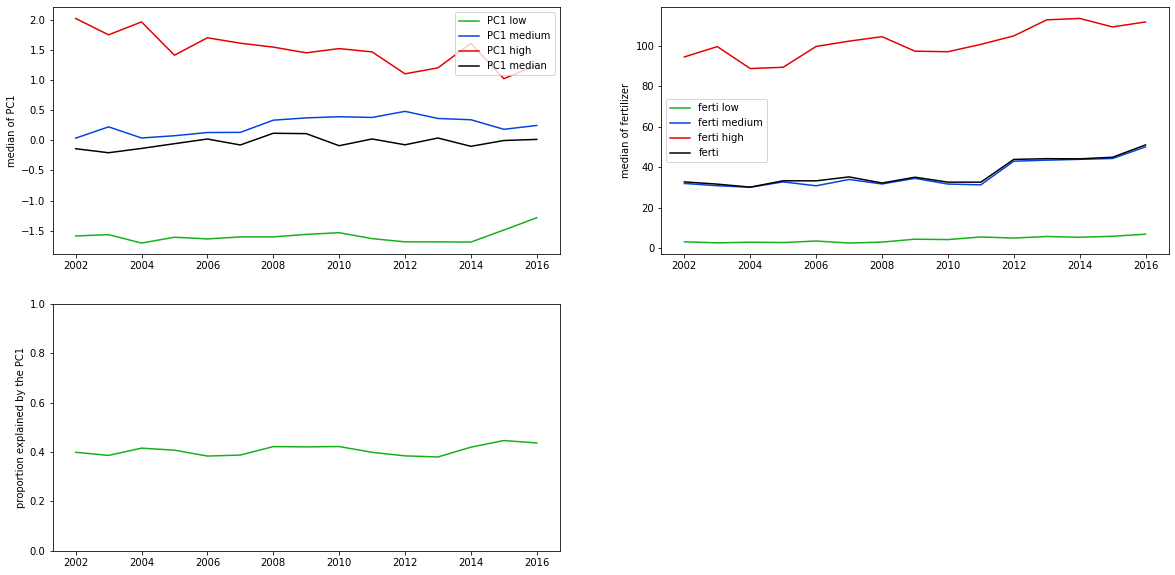

In [105]:
evolution_ferti = pd.DataFrame([years, PC1_low, PC1_medium, PC1_high, ferti_low, ferti_medium, ferti_high,ferti,PC1, proportion_explained], ['year', 'PC1 low', 'PC1 medium', 'PC1 high','ferti low', 'ferti medium', 'ferti high','ferti','PC1 median', 'proportion explained']).T

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("year", "PC1 low", data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax1.plot("year", "PC1 medium", data=evolution_ferti, color=sns.xkcd_palette(colors)[1])
ax1.plot("year", "PC1 high", data=evolution_ferti, color=sns.xkcd_palette(colors)[2])
ax1.plot("year", "PC1 median", data=evolution_ferti, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of PC1')
ax1.legend()

ax2 = figure.add_subplot(2,2,2)
ax2.plot("year", "ferti low", data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax2.plot("year", "ferti medium", data=evolution_ferti, color=sns.xkcd_palette(colors)[1])
ax2.plot("year", "ferti high", data=evolution_ferti, color=sns.xkcd_palette(colors)[2])
ax2.plot("year", "ferti", data=evolution_ferti, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of fertilizer')
ax2.legend()

ax3 = figure.add_subplot(2,2,3)
ax3.plot("year", 'proportion explained', data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax3.set_ylabel('proportion explained by the PC1')
ax3.set_ylim([0,1])

**Observation:** 
- While the PC1 remains relatively stable for the low fertilizer and the medium fertilizer groups, it clearly decreases overtime for the high fertilizer group. 
- At the same time, fertilizer use keeps increasing for all the groups.
- The explained proportion remains relativaly stable around 0.4 overtime, showing that PCA performed quite well for all years.

We observed this relationship when considering groups of countries. Can we see the same tendancy with one single country of each group?

In [26]:
years = []
Burkina_Faso_pca = []
Armenia_pca = []
Belgium_pca = []
Burkina_Faso_ferti = []
Armenia_ferti = []
Belgium_ferti = []
proportion_explained = []
for year in range(2002,2017):
    years += [year]
    
    grouped_yield=crops.query('`Element Code` == 5419')\
                                .query('`Year Code` == @year')\
                                .query('`Item Code` >1000')\
                                .pivot(index='Area',columns='Item',values='Value')\
                                .fillna(value=0)\
                                .reset_index()

    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])


    fertilizer=(fertilizer_area.query('`Item Code` == (3102)')
        .query('`Year Code` == @year')
        .query('`Area Code` <300')
        .sort_values('Value', ascending=False)
    )

    grouped_yield_pca=pd.merge(grouped_yield_pca,fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
    grouped_yield_pca['ferti_class']=grouped_yield_pca.Value.apply(lambda x: ferti_class(x, grouped_yield_pca.Value))

    Burkina_Faso_pca += [grouped_yield_pca[grouped_yield_pca.Area=='Burkina Faso'].PC1.values[0]]
    Armenia_pca += [grouped_yield_pca[grouped_yield_pca.Area=='Armenia'].PC1.values[0]]
    Belgium_pca += [grouped_yield_pca[grouped_yield_pca.Area=='Belgium'].PC1.values[0]]
    Burkina_Faso_ferti += [grouped_yield_pca[grouped_yield_pca.Area=='Burkina Faso'].Value.values[0]]
    Armenia_ferti += [grouped_yield_pca[grouped_yield_pca.Area=='Armenia'].Value.values[0]]
    Belgium_ferti += [grouped_yield_pca[grouped_yield_pca.Area=='Belgium'].Value.values[0]]
                    
    proportion_explained += [pca.explained_variance_ratio_[0]]
    
    

(0, 1)

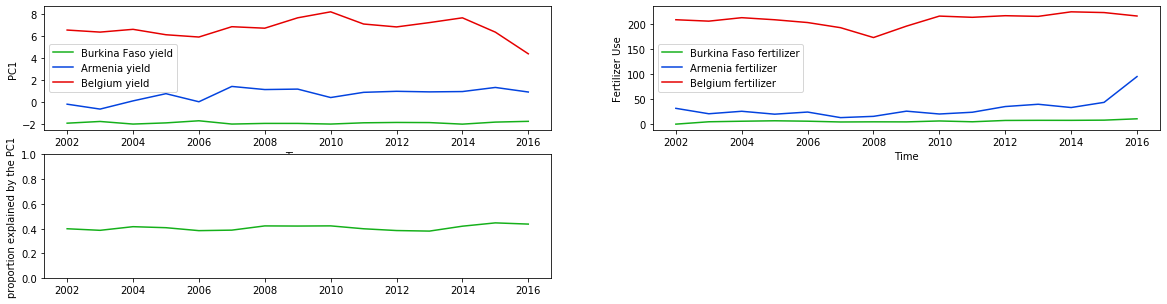

In [106]:
evolution_ferti = pd.DataFrame([years, Burkina_Faso_pca, Armenia_pca, Belgium_pca,Burkina_Faso_ferti, Armenia_ferti, Belgium_ferti,proportion_explained], ['year', 'Burkina Faso yield', 'Armenia yield', 'Belgium yield','Burkina Faso fertilizer', 'Armenia fertilizer', 'Belgium fertilizer','proportion explained']).T

figure = plt.figure(figsize = (20,5))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("year", "Burkina Faso yield", data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax1.plot("year", "Armenia yield", data=evolution_ferti, color=sns.xkcd_palette(colors)[1])
ax1.plot("year", "Belgium yield", data=evolution_ferti, color=sns.xkcd_palette(colors)[2])
ax1.set_ylabel('PC1')
ax1.set_xlabel('Time')
ax1.legend()

ax2 = figure.add_subplot(2,2,2)
ax2.plot("year", "Burkina Faso fertilizer", data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax2.plot("year", "Armenia fertilizer", data=evolution_ferti, color=sns.xkcd_palette(colors)[1])
ax2.plot("year", "Belgium fertilizer", data=evolution_ferti, color=sns.xkcd_palette(colors)[2])
ax2.set_ylabel('Fertilizer Use')
ax2.set_xlabel('Time')
ax2.legend()

ax3 = figure.add_subplot(2,2,3)
ax3.plot("year", 'proportion explained', data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax3.set_ylabel('proportion explained by the PC1')
ax3.set_ylim([0,1])

**Observation:** 
We observe the same tendancy with one single country for each group.

## Part 3 : UMAP Analysis - Dimensionality Reduction to 1 Dimension

After studying the relationship using PCA, we wanted to test another non-linear dimensionality reduction method in order to see if we find comparable results. 

First, we create a function which applies the UMAP method to the yield data for a given year and computes a linear regression between fertilizer use and the umap result.

In [108]:
# Creation of a function doing the umap (works also for only 1 dimension end)
def umap_year(year, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .pivot(index='Area',columns='Item',values='Value')
            .fillna(value=0)
            .reset_index()
              )
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values # To perform the umap, we need to select only the features
    
    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    umap_fertilizer=(fertilizer_area
                    .query('Year == @year')
                    .query('`Area Code` <300')
                    .query('`Item Code` == (3102)')
                    .loc[:,['Area','Value']]
                    )
    embedding2=pd.merge(embedding2,umap_fertilizer,left_on='Area',right_on='Area')
    embedding2[0]=embedding2[0]/max(embedding2[0])
    embedding2['Value']=embedding2['Value']/max(embedding2['Value'])
    embedding2['ferti_class']=embedding2.Value.apply(lambda x: ferti_class(x, embedding2.Value))
    
    coef = np.polyfit(embedding2[0],embedding2.Value,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

We visualize for one year (2016) the regression result for umap result vs fertilizer use.

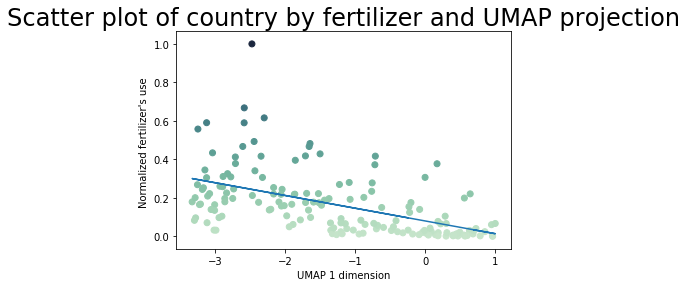

[-0.06629834  0.07961216]


In [124]:
#Visualization for year 2016

vis_2016=umap_year(2016,1)

embedding2=vis_2016[1] 
coef = vis_2016[2]
poly1d_fn = np.poly1d(coef)
clarity_ranking = embedding2.Value

cmap = sns.cubehelix_palette(as_cmap=True,rot=-.4)
plt.scatter(embedding2[0], embedding2.Value,c=clarity_ranking, cmap=cmap)
plt.plot(embedding2[0], poly1d_fn(embedding2[0]))
plt.gca().set_aspect('auto', 'datalim')
plt.title('Scatter plot of country by fertilizer and UMAP projection', fontsize=24);
plt.xlabel("UMAP 1 dimension")
plt.ylabel("Normalized fertilizer's use ")
plt.show()
print(coef)

We see that fertilizer use is higher towards the left. There is a negative correlation between UMAP1 and fertilizer use, confirming that there is a correlation between the reduced dimension representation of yield and fertilizer use.  

1 outliers is present and coincides with the highest value of fertilizer use. Let's check which country this is:

In [125]:
# looking at countries names
embedding2.sort_values(by='Value',ascending=False).head(1)

,0,Area,Value,ferti_class
46,-2.471586,Egypt,1.0,high


In [126]:
# Looking at yield for these countries
grouped_yields.loc[grouped_yields.Area.isin(['Egypt'])]

Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fruit Primary,"Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
69,Egypt,67013.0,72493.0,244379.0,69967.0,226365.0,28615.0,265779.0,57190.0,240120.0


From a first look, there is nothing strange about their data and looking back at the FAO dataset there is no unusual flag set for this country. 
Therefore, it may be interesting to look further in to this outlier. 


Next we visualize the distribution of umap value for each fertilizer class (low, medium, high):

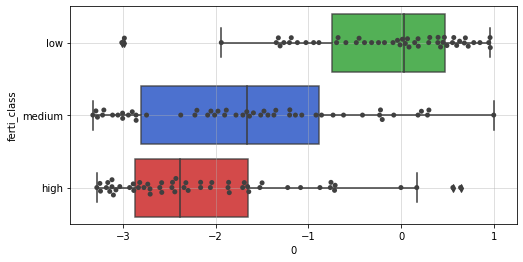

In [127]:
#Boxplot of umap 1-dim with country fertilizer's use classified in 3 different equaly sized group 
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
#cmap = sns.cubehelix_palette(rot=-.4)
ax = sns.boxplot(x=embedding2[0], y='ferti_class', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[0], y='ferti_class', data=embedding2, color=".25")
ax.grid(alpha=0.5)

Here we can see that higher fertilizer use is on the left and there is a significant difference between the high/medium fertilizer use groups and the low fertilizer use group.

Next we perform a umap analysis for each year and look at the evolution of the coefficient of the linear regression of umap vs fertilizer use:

In [117]:
# umap for all years available in the fertilizer dataset (the more restrictive dataset)
mean=[]
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    adding=umap_year(year,1)
    mean.append([adding[0],adding[2][0]])
mean=pd.DataFrame(mean)

Text(0.5, 1.0, 'Evolution of linear regression (fertilizer/axe0) over the year')

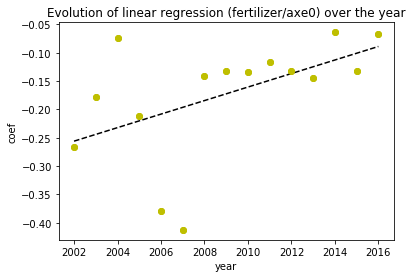

In [128]:
# look at coef over the years
coef = np.polyfit(mean[0],mean[1],1) #test regression dim 1 ...
poly1d_fn = np.poly1d(coef)
plt.plot(mean[0],mean[1], 'yo',mean[0], poly1d_fn(mean[0]), '--k')
plt.plot(mean[0],mean[1], 'yo')
plt.xlabel('year')
plt.ylabel('coef')
plt.title('Evolution of linear regression (fertilizer/axe0) over the year')

Here we can see that the absolute value of the coefficient is decreasing, showing that the correlation between fertilizer use and umap value is decreasing overtime. 

In [122]:
#Compute error of the regression
stats.linregress(mean[0],mean[1])

LinregressResult(slope=0.01193634107509808, intercept=-24.152669935827404, rvalue=0.507656591196675, pvalue=0.05338164141186508, stderr=0.005618427668196246)

## Summary from Parts 2 and 3:

So far, we have seen from Part 2 that yields are not necessarily increasing despite a consistent increase in fertilizer use overtime. 
Part 3 confirms this observation because we see that the correlation between fertilizer use and umap value (which is a one dimensional representation of the yield) is decreasing - therefore knwoing that the consumption of fertilizer is increasing, this can be interpreted as a decrease in the positive effect of fertilizer on yield.

This is an interesting observation as it indicates that we may have a situation where a given increase in fertilizer use is no longer producing the same increase in yield as it has in the past. 

This is also interesting given that besides influencing yield, fertilizer also has an environmental impact. Typically this is 'justified' by the fact that it helps to produce the higher yields required to feed our growing population. However, if the benefits of fertilizer use are no longer clear, this could be an argument for moving towards alternative forms of agriculture.

In order to further our analysis, we will look further in to the environmental impacts of agriculture (and particularly of fertilizer) below.

## Part 4 : Environmental impact


Here, we will look to understand the relationshp between the environmental impacts of fertilizer use and agricultural yields and see if we observe similar relationshps to the fertilizer use and yield relationship studied in parts 2 and 3.

In [151]:
#Load the data set
total_emissions = pd.read_csv('./data/Emissions_AllAgriculture.csv', sep=',', encoding = 'latin-1')
total_emissions.columns = ('domain_code', 'domain', 'area_code','area', 'element_code','element','item_code', 'item','year_code','year','unit','value','flag', 'flag_description','note')
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1962,1962,gigagrams,5151.5228,A,"Aggregate, may include official, semi-official...",NaN


First we will look at the evolution of global emissions due to agriculture per year, and then more specifically the evolution of global emissions due to fertilizer use per year.

In [152]:
#First let's look at global emissions evolution per year 
total_per_year = total_emissions.groupby('year').sum()
total_per_year.head(2)

,area_code,element_code,item_code,year_code,value,note
year,,,,,,
1961,171113,10000473,7000191,2712063,3.005584e+06,0.0
1962,171113,10000473,7000191,2713446,3.069126e+06,0.0


In [153]:
#And since we are focusing on fertilizers, let's look specficifally at the fertilizer emissions as well
fert_emissions = total_emissions.query("item == 'Synthetic Fertilizers'")
fert_emissions = fert_emissions.groupby('year').sum()
fert_emissions.head(2)

,area_code,element_code,item_code,year_code,value,note
year,,,,,,
1961,21855,1279887,895797,347097,78306.1006,0.0
1962,21855,1279887,895797,347274,90023.8397,0.0


Text(0.5, 1.0, 'Global Agriculture Emissions from Synthetic Fertilizers\n')

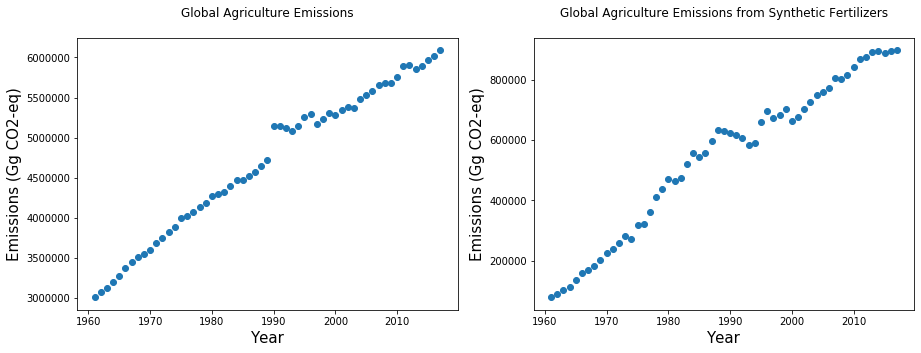

In [154]:
fig = plt.figure(figsize = (15, 5))

ax1 = fig.add_subplot(1, 2, 1)
plt.scatter(total_per_year.index.values, total_per_year.value)
ax1.set_xlabel("Year", fontsize=15)
ax1.set_ylabel("Emissions (Gg CO2-eq)", fontsize=15)
ax1.set_title("Global Agriculture Emissions\n")

ax2 = fig.add_subplot(1,2,2)
plt.scatter(fert_emissions.index.values, fert_emissions.value)
ax2.set_xlabel("Year", fontsize=15)
ax2.set_ylabel("Emissions (Gg CO2-eq)", fontsize=15)
ax2.set_title("Global Agriculture Emissions from Synthetic Fertilizers\n")

We can see that both are increasing (as expected) - although the emissions due to fertilizer appear to be slowing in increase over the last few years.

For global agricultural emissions, we can see that there is a weird jump roughly around the year 1990. Let's figure out why that is:

In [155]:
#First look for the exact year where the jump occurs
total_per_year.loc[1988:1992]

,area_code,element_code,item_code,year_code,value,note
year,,,,,,
1988,173018,10108938,7076127,2779224,4.642316e+06,0.0
1989,173018,10108938,7076127,2780622,4.717353e+06,0.0
1990,211837,12365010,8814324,3402900,5.146297e+06,0.0
1991,211170,12336086,8794098,3396646,5.140631e+06,0.0
1992,230556,13493046,9619349,3717072,5.125552e+06,0.0


We see above that the discontinuity occurs between 1989 and 1990.

One possible reason for this could be that data for more areas became available in this year - let's check:

In [156]:
emissions_1989 = total_emissions.query("year == 1989").groupby('area').sum()
countries_1989 = len(emissions_1989.index)
print(countries_1989)

195


In [157]:
emissions_1990 = total_emissions.query("year == 1990").groupby('area').sum()
countries_1990 = len(emissions_1990.index)
print(countries_1990)

208


It seems that our hypothesis was correct and the discontinuity can be explained by the addition of many more areas starting in 1990.

Now we want to continue our analysis on the relationship between yield and environmental impacts (and in particular environmental impacts of fertilizer).

In order to effectively compare impacts between countries, we will consider emissions per ha of agricultural land rather than total emissions, therefore first let's calculate this value:

In [158]:
total_area=pd.read_csv('./data/LandUse.csv',sep=',',encoding='latin-1')
total_area_agriculture = total_area.query("Item == 'Agriculture'")
total_area_agriculture.head(2)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
114,RL,Land Use,2,Afghanistan,5110,Area,6602,Agriculture,1961,1961,1000 ha,37700.0,Fc,Calculated data
115,RL,Land Use,2,Afghanistan,5110,Area,6602,Agriculture,1962,1962,1000 ha,37760.0,Fc,Calculated data


In [159]:
total_emissions = pd.merge(total_emissions, total_area_agriculture.loc[:,['Value', 'Area','Year']], left_on = ['area','year'], right_on = ['Area','Year'])
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5059,Manure Management,1961,1961,gigagrams,367.8310,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961


In [160]:
total_emissions['emissions_ha'] = total_emissions.value / total_emissions.Value
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.134068
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5059,Manure Management,1961,1961,gigagrams,367.8310,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.009757


Next we define some functions for classifying the level of emissions (as was done above for fertilizer use):

In [161]:
def emissions_class(x): 
    if x<low :
        return 0
    elif low<=x<medium:
        return 1
    else:
        return 2

In [162]:
def emissions_class2(x): 
    if x<low :
        return 'low'
    elif low<=x<medium:
        return 'medium'
    else:
        return 'high'

We will perform a umap dimensionality reduction to 2 dimensions on the yield data and visualize this in relation to the emissions classifications, therefore we will also load the yield dataset and prepare it for the dimensionality reduction analysis:

In [163]:
#load the yield dataset
total_yield=pd.read_csv('./data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
total_yield.head(2)


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0.0,F
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,1976,ha,5900.0,F


In [164]:
grouped_yield = total_yield.query('`Element Code` == 5419').query('`Item Code` >1000')
grouped_yield = grouped_yield.groupby(['Item','Year']).sum()
grouped_yield.head(2)

Area Code  Item Code  Element Code  Year Code  \
Item                      Year                                                  
Cereals (Rice Milled Eqv) 1961     191204     345230       1029610     372590   
                          1962     191204     345230       1029610     372780   

                                    Value  
Item                      Year             
Cereals (Rice Milled Eqv) 1961  2392177.0  
                          1962  2507171.0

In [165]:
#Prepare the yield dataset for umap dimensional reduction analysis:

grouped_yield_2016=(total_yield.query('`Element Code` == 5419') #by yield
        .query('`Year Code` == 2016') 
        .query('`Item Code` >1000') #grouped crops
        .pivot(index='Area',columns='Item',values='Value')
        .fillna(value=0)
        .reset_index()
          )
grouped_yield_2016.head(2)

Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fruit Primary,"Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,Afghanistan,19391.0,19816.0,83127.0,16667.0,88201.0,7406.0,119868.0,15984.0,91869.0
1,Africa,14245.0,15261.0,108260.0,13007.0,88514.0,7629.0,85875.0,5437.0,83707.0


In [166]:
yield_2016 = grouped_yield_2016.drop('Area',axis=1).values

#Normalization 
from sklearn import preprocessing

x = yield_2016
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
yield_2016 = pd.DataFrame(x_scaled)

For a first analysis, we will look at the year 2016 - therefore we will first isolate the emissions from this year, starting with all emissions:

In [167]:
emissions_2016 = total_emissions.query('year == 2016').groupby('area').sum()
emissions_2016.head(2)

,area_code,element_code,item_code,year_code,year,value,note,Value,Year,emissions_ha
area,,,,,,,,,,
Afghanistan,18,65079,45560,18144,18144,13832.9964,0.0,341190.0,18144,0.364890
Albania,30,72310,52319,20160,20160,2924.0750,0.0,11817.0,20160,2.474465


In [168]:
#define the low and medium values to be used for classification of the emisisons data
low = np.percentile(emissions_2016.emissions_ha, 33.0)
medium = np.percentile(emissions_2016.emissions_ha, 66.0)

Next we apply umap to the data and classify in terms of emissions:

In [170]:
import umap

reducer = umap.UMAP(random_state=1)
embedding = reducer.fit_transform(yield_2016)
embedding2=pd.DataFrame(embedding)
embedding2=pd.merge(embedding2,grouped_yield_2016['Area'], left_index=True, right_index=True)
embedding2=pd.merge(embedding2,emissions_2016.loc[:,['emissions_ha']],left_on='Area',right_index = True)
embedding2['emissions_class']=embedding2.emissions_ha.apply(emissions_class)
embedding2['emissions_class2']=embedding2.emissions_ha.apply(emissions_class2)
embedding2.head(2)

,0,1,Area,emissions_ha,emissions_class,emissions_class2
0,1.854531,-2.525235,Afghanistan,0.364890,0,low
2,1.327653,1.611457,Albania,2.474465,2,high


Finally we visualize the umap results and the distribution with respect to each emissions class.

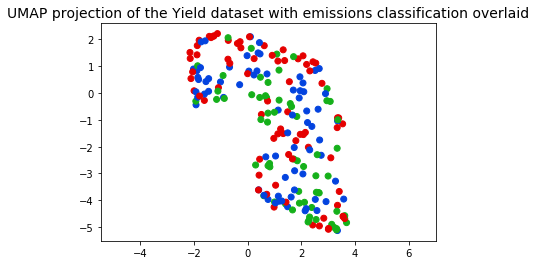

In [171]:
#Visualize 
plt.scatter(embedding2[0], embedding2[1], c=[sns.xkcd_palette(colors)[x] for x in embedding2.emissions_class.values])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Yield dataset with emissions classification overlaid', fontsize=14);

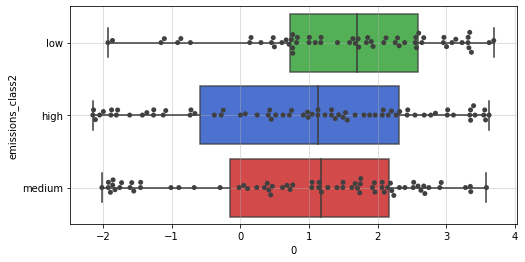

In [172]:
#Box plot x axis
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
#cmap = sns.cubehelix_palette(rot=-.4)
ax = sns.boxplot(x=embedding2[0], y='emissions_class2', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[0], y='emissions_class2', data=embedding2, color=".25")
ax.grid(alpha=0.5)

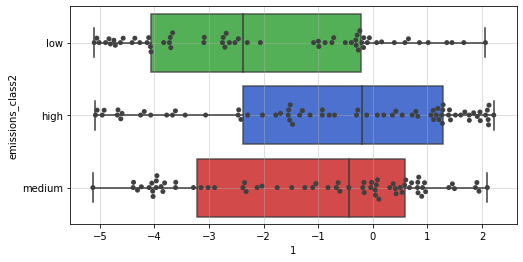

In [173]:
#Box plot y axis
fig = plt.figure(figsize = (8,4))
#sns.palplot(sns.cubehelix_palette(3))
colors = ["green", "blue", "red"]
ax = sns.boxplot(x=embedding2[1], y='emissions_class2', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[1], y='emissions_class2', data=embedding2, color=".25")
ax.grid(alpha=0.5)

We can see above that considering overall emissions, there is not a very notable difference between the yield characteristics of the low, medium and high emissions groups. 

This could be interesting in itself - however, it should be noted that for yield we are only considering crops, whereas overall emissions are highly affected by agricultural practices (such as burning), as well as livestock. Therefore, in a way it makes sense that the yield of crops does not differentiate between these groups.

However, the situation may be different if we consider the emissions due to fertilizers only - let's look at this:

In [174]:
fert_emissions_2016 = total_emissions.query("item == 'Synthetic Fertilizers'").query('year == 2016').groupby('area').sum()
fert_emissions_2016.head(2)

,area_code,element_code,item_code,year_code,year,value,note,Value,Year,emissions_ha
area,,,,,,,,,,
Afghanistan,2,7231,5061,2016,2016,623.9758,0.0,37910.0,2016,0.016459
Albania,3,7231,5061,2016,2016,276.8789,0.0,1181.7,2016,0.234306


In [175]:
#calculate the new low and medium levels
low = np.percentile(fert_emissions_2016.emissions_ha, 33.0)
medium = np.percentile(fert_emissions_2016.emissions_ha, 66.0)

In [176]:
#perform a new umap analysis
reducer_new = umap.UMAP(random_state=1)
embedding_new = reducer_new.fit_transform(yield_2016)
embedding2_new=pd.DataFrame(embedding_new)
embedding2_new=pd.merge(embedding2_new,grouped_yield_2016['Area'], left_index=True, right_index=True)
embedding2_new=pd.merge(embedding2_new,fert_emissions_2016.loc[:,['emissions_ha']],left_on='Area',right_index = True)
embedding2_new['emissions_class']=embedding2_new.emissions_ha.apply(emissions_class)
embedding2_new['emissions_class2']=embedding2_new.emissions_ha.apply(emissions_class2)
embedding2_new.head(2)

,0,1,Area,emissions_ha,emissions_class,emissions_class2
0,1.854531,-2.525235,Afghanistan,0.016459,0,low
2,1.327653,1.611457,Albania,0.234306,1,medium


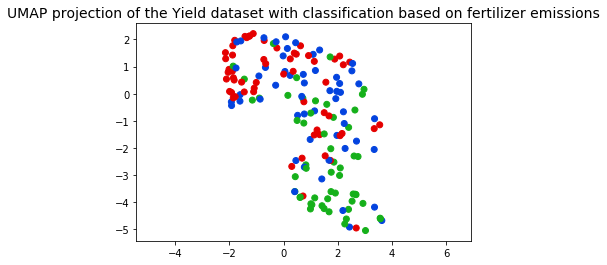

In [177]:
plt.scatter(embedding2_new[0], embedding2_new[1], c=[sns.xkcd_palette(colors)[x] for x in embedding2_new.emissions_class.values])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Yield dataset with classification based on fertilizer emissions', fontsize=14);

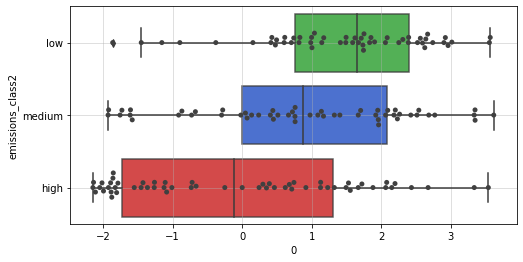

In [178]:
#Box plot x axis
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
ax = sns.boxplot(x=embedding2_new[0], y='emissions_class2', data=embedding2_new, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2_new[0], y='emissions_class2', data=embedding2_new, color=".25")
ax.grid(alpha=0.5)

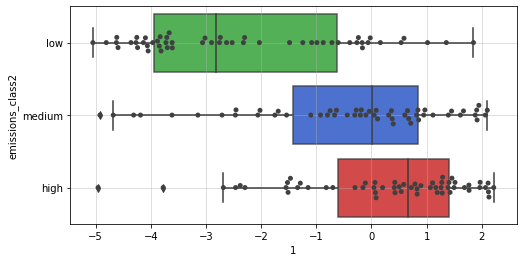

In [179]:
#Box plot y axis
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
ax = sns.boxplot(x=embedding2_new[1], y='emissions_class2', data=embedding2_new, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2_new[1], y='emissions_class2', data=embedding2_new, color=".25")
ax.grid(alpha=0.5)

Looking at the plots above, we see that considering fertilizer emissions, there is a notable difference betweem the low and medium/high emissions categories when compared to the reduced dimensionality x value, and a notable difference between the low and the medium/high emissions categories when compared to the reduced dimensionality y value.


Next we want to consider further the differences and similarities between these groups.
For example, what are the differences between groups and why?
Which places are 'outliers', with similar yield characteristics but drastically different emissions, or vice versa?

Initially, we take a deeper look at these outlier cases:

For example, inspecting the "low" emissions group, we find that Australia has synthetic fertilizer emissions in the low range, but has yield characteristics more similar to that of countries with medium to high emissions such as spain:

In [180]:
embedding2_new.query("Area == ['Australia','Spain']")

,0,1,Area,emissions_ha,emissions_class,emissions_class2
11,0.478853,0.589596,Australia,0.018335,0,low
206,0.238509,0.673006,Spain,0.241359,1,medium


Let's take a closer look at the data we have for emissions and crop yields of these countries:

In [182]:
fert_emissions_2016.query("area == ['Australia','Spain']")

,area_code,element_code,item_code,year_code,year,value,note,Value,Year,emissions_ha
area,,,,,,,,,,
Australia,10,7231,5061,2016,2016,6803.8569,0.0,371078.0,2016,0.018335
Spain,203,7231,5061,2016,2016,6339.4598,0.0,26265.7,2016,0.241359


In [183]:
grouped_yield_2016.query("Area == ['Australia','Spain']")

Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fruit Primary,"Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
11,Australia,20698.0,20752.0,199756.0,22375.0,142540.0,11965.0,401728.0,17488.0,258512.0
206,Spain,38179.0,38625.0,239620.0,39736.0,122106.0,13873.0,309510.0,3796.0,391402.0


Above we can see that Australia has a similar value of absolute value of emissions as well as a larger agricultural area than Spain, ultimately leading it to have a much lower value of emissions per ha of agricultural area. 

And the yield data is indeed similar, with some exceptions (notably Spain produces more grains and vegetables, and Australia produces more roots and tubers and treenuts).

### Summary of Part 4:

So far we have only looked at the year 2016. To go further, we can extend the analysis to multiple years (as was done in the yield/fertilizer application section) to see how the relationship between crop yield and fertilizer emissions has been evolving.

We can also look deeper into what causes certain countries (i.e. Australia and Spain) to have similar yields but drastically different emissions due to fertilizers, as well as further into the yield characteristics of each separate emissions group.

## Conclusion : 

Overall, we have found the interesting result that the effectiveness of fertilizer may be decreasing overtime (due to the decreasing positive correlation between fertilizer use and yield observed in parts 2 and 3), and that increased environmental impacts due to fertilizer use are not necessarily associated with "better" yields (as we can see in Part 4 for as there are certain countries which have comparable yield characteristics but very different emissions values). 

These insights will be the focus of our further analysis and final project. 


To link our observations to what is actually going on today, we have two hypotheses: 
- We have reached a saturation point in the effectiveness of fertilizer
- Fertilizer use is associated (directly or not) with degradation of soil quality so at first we can achieve higher yields with more fertilizer but overtime this can no longer be achieved

We will continue to look deeper in to this.